# Ejercicio 2: "Analizando nuestro modelo" (obligatorio)

Usando como base alguno de los dos ejemplos realizar código que:
1. Calcule la matriz de confusión para los dígitos. La matriz de confusión es una métrica, por lo que debe ser calculada sólo en validación.
2. Utilizando la matriz de confusión elegir el par de dígitos dónde el modelo se confunde más y mostrar 20 ejemplos mal clasificados.
3. Una función que muestre los 20 ejemplos de validación con mayor costo. Intuitivamente estos son los ejemplos donde el modelo está más errado: arroja probabilidades altas para clases que no son la correcta.
4. Una función que muestre los 20 ejemplos de validación donde el modelo arroja probabilidades más bajas. Esto se puede interpretar como que el modelo está "poco seguro" para estos casos.

Todo este trabajo de visualización suele ser comun realizarlo cuando se trabaja con datasets reales para limpiar el dataset de ejemplos malformados, maletiquetados, etc.
En caso de utilizarlo para limpiar el dataset hay que realizarlo sobre todo el conjunto de datos (no sólo validación). Y es importante que el modelo no llegue a sobre-ajustar ni un poco (ya que usaremos por ejemplo el costo en training para limpiar el dataset).

# Solución

Para la solucion de este ejercicio se parte del ejercicio 1. 

Repetimos el codigo y sacamos notas que no son necesarias

## Importacion de librerias

In [36]:
import torch
from torch import nn
#from torch.utils.data import TensorDataset, random_split

import numpy as np
from matplotlib import pyplot
import math
#---------------------------------------------------
import requests
from pathlib import Path
import pickle
import gzip
from torch.utils.data import TensorDataset, DataLoader
import torchvision.models

## Preparación del dataset

In [26]:
DATA_PATH = Path("../data")
PATH = DATA_PATH / "mnist"

# Creara ../data/mnist si no existe 
# (si no existe ./data lo creará y creará ./data/mnist)
# (y si existe pero no existe ./data/mnist sólo creará este último).
# Cualquier cuestión que no se entienda, consultar la documentación de las librerías
# por ejemplo https://docs.python.org/3/library/pathlib.html
PATH.mkdir(parents=True, exist_ok=True)

URL = "https://github.com/pytorch/tutorials/raw/main/_static/"
FILENAME = "mnist.pkl.gz"

# Descargamos mnist.pkl.gz utilizando un HTTP GET request
if not (PATH / FILENAME).exists():
        content = requests.get(URL + FILENAME).content
        (PATH / FILENAME).open("wb").write(content)



In [46]:
# Los arrays de las imagenes fueron guardados en un archivo formato pickle, que se utiliza para persistir variable en Python
with gzip.open((PATH / FILENAME).as_posix(), "rb") as f:
        ((x_train, y_train), (x_valid, y_valid), _) = pickle.load(f, encoding="latin-1")

In [47]:
x_train.shape, y_train.shape, x_valid.shape, y_valid.shape

((50000, 784), (50000,), (10000, 784), (10000,))

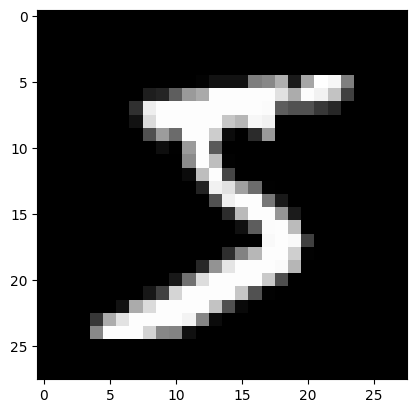

In [29]:
pyplot.imshow(x_train[0].reshape((28, 28)), cmap="gray")
pyplot.show()

### Reshape

 Resnet espera que le pasen un tensor de dimensiones $(3,H,W)$ siendo $3$ la cantidad de canales, $H$ la altura de una imágen y $W$ la anchura.

Para aplicarlo, debemos des-aplanar las 784 features que componene cada sample. Lo hacemos en x_train y x_valid

In [49]:
x_train = x_train.reshape(-1,1,28,28)
x_valid = x_valid.reshape(-1,1,28,28)

In [50]:
x_train.shape, y_train.shape, x_valid.shape, y_valid.shape

((50000, 1, 28, 28), (50000,), (10000, 1, 28, 28), (10000,))

In [54]:
x_train = np.repeat(x_train, 3, axis=1)
x_valid = np.repeat(x_valid, 3, axis=1)


In [55]:
x_train.shape, y_train.shape, x_valid.shape, y_valid.shape

((50000, 3, 28, 28), (50000,), (10000, 3, 28, 28), (10000,))

In [56]:
train_dataset = TensorDataset(torch.tensor(x_train), torch.tensor(y_train))
valid_dataset = TensorDataset(torch.tensor(x_valid), torch.tensor(y_valid))

Definio el tamaño del batch

In [57]:
batch_size=32

In [58]:
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
valid_dataloader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False)

In [59]:
n_batches_train = len(train_dataloader) // batch_size
n_batches_valid = (len(valid_dataloader) + batch_size - 1) // batch_size

print(f"Batch en train: {n_batches_train}")
print(f"Batch en valid: {n_batches_valid}")

Batch en train: 48
Batch en valid: 10


## Creación de la red
### Definición de la red
Para este caso seria modificación de la red

### Instanciación de la clase

In [65]:
resnet_model = torchvision.models.resnet34(pretrained=True)
resnet_model

/Volumes/GEROEXT/MCD/llm/llm-austral/.venv/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Volumes/GEROEXT/MCD/llm/llm-austral/.venv/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet34_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet34_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

### Función de pérdida

Creación de la función de pérdida basada en la log-verosimilitud negativa

La función nn.NLLLoss() mide la diferencia entre las probabilidades predichas por el modelo y las etiquetas reales. Se utiliza generalmente en problemas de clasificación donde el modelo genera log-probabilidades como salida.

In [66]:
loss_func = nn.NLLLoss()

### Optimizador

Creacion del optimizador 

Especificamos el algoritmo de optimización <strong>Descenso de Gradiente Estocástico (SGD)</strong>. Este algoritmo ajusta los parámetros del modelo en la dirección del gradiente negativo para minimizar la función de pérdida.

In [67]:
optimizer = torch.optim.SGD(resnet_model.parameters(), lr=0.001)

### Funciones auxiliares

Creamos la funcion para medir la proporción de predicciones correctas sobre el total de predicciones realizadas.


In [68]:
def accuracy(probs, target):
    class_predictions = torch.argmax(probs, dim=1)
    return (class_predictions == target).float().mean()

### Modificacion de la ultima capa

In [69]:
num_features = resnet_model.fc.in_features 
resnet_model.fc = nn.Linear(num_features, 10)

### Congelar capas anteriores

In [70]:
for param in resnet_model.parameters():
    param.requires_grad = False

# Ahora sólo la capa final quedará entrenable
resnet_model.fc = nn.Linear(num_features, 10)
# Reasignamos param.requires_grad = True explícitamente para la capa fc
for param in resnet_model.fc.parameters():
    param.requires_grad = True


In [71]:
if torch.backends.mps.is_available():
    device = torch.device("mps")
    print("Using MPS")
else:
    device = torch.device("cpu")
    print("Using CPU")

resnet_model.to(device)

Using MPS


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

## Training loop usando Pytorch:

In [80]:
n_epochs = 15
for idx_epoch in range(n_epochs):
    # Loop de entrenamiento
    loss_train_sum = 0
    n_batches_train = 0
    for x_train_batch, y_train_batch in train_dataloader:
        x_train_batch = x_train_batch.to(device, dtype=torch.float32)
        y_train_batch = y_train_batch.to(device, dtype=torch.int64)
        predictions = resnet_model(x_train_batch)
        loss = loss_func(predictions, y_train_batch)
        loss_train_sum += loss.item()
        n_batches_train += 1
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    # Evaluamos los datos en validación
    loss_validation_sum = 0
    accuracy_sum = 0
    for x_valid_batch, y_valid_batch in valid_dataloader:
        x_valid_batch = x_valid_batch.to(device, dtype=torch.float32)
        y_valid_batch = y_valid_batch.to(device, dtype=torch.int64)
        predictions = resnet_model(x_valid_batch)
        loss = loss_func(predictions, y_valid_batch)
        loss_validation_sum += loss.item()
        accuracy_sum += accuracy(predictions, y_valid_batch).item()
    
    # Imprimimos el loss en train y validación y la métrica (siempre en validación)
    accuracy_validation = accuracy_sum / n_batches_valid
    loss_validation = loss_validation_sum / n_batches_valid
    train_validation = loss_train_sum / n_batches_train
    print(f'epoch {idx_epoch} | train loss {loss_validation} | validation loss {train_validation} | accuracy {accuracy_validation}')

epoch 0 | train loss -8.132512798532844 | validation loss -0.2313301571634713 | accuracy 3.25625
epoch 1 | train loss -8.132512798532844 | validation loss -0.23154364558150103 | accuracy 3.25625
epoch 2 | train loss -8.132512798532844 | validation loss -0.23286519336299072 | accuracy 3.25625
epoch 3 | train loss -8.132512798532844 | validation loss -0.2338462615557258 | accuracy 3.25625
epoch 4 | train loss -8.132512798532844 | validation loss -0.23266132330189454 | accuracy 3.25625
epoch 5 | train loss -8.132512798532844 | validation loss -0.23410136534243117 | accuracy 3.25625
epoch 6 | train loss -8.132512798532844 | validation loss -0.23225081143561113 | accuracy 3.25625
epoch 7 | train loss -8.132512798532844 | validation loss -0.231166595137861 | accuracy 3.25625
epoch 8 | train loss -8.132512798532844 | validation loss -0.23379244641606445 | accuracy 3.25625
epoch 9 | train loss -8.132512798532844 | validation loss -0.23416389743079474 | accuracy 3.25625
epoch 10 | train loss -8

## Analisis matriz de confusión

Para este punto nos ayudamos de la libreria sklearn


In [81]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

In [83]:
resnet_model.eval()  # Modo evaluación

all_preds = []
all_targets = []

misclassified_images = []
misclassified_preds = []
misclassified_labels = []

with torch.no_grad():
    for x_valid_batch, y_valid_batch in valid_dataloader:
        x_valid_batch = x_valid_batch.to(device, dtype=torch.float32)
        y_valid_batch = y_valid_batch.to(device, dtype=torch.int64)
        # forward pass
        predictions = resnet_model(x_valid_batch)
        # argmax para obtener la clase predicha (0..9 en MNIST)
        pred_labels = predictions.argmax(dim=1)
        
        # Guardamos en listas (o tensores) para luego generar la matriz de confusión
        all_preds.append(pred_labels.cpu().numpy())  
        all_targets.append(y_valid_batch.cpu().numpy())
        for i in range(len(pred_labels)):
            if pred_labels[i] != y_valid_batch[i]:
                misclassified_images.append(x_valid_batch[i])
                misclassified_preds.append(pred_labels[i].item())
                misclassified_labels.append(y_valid_batch[i].item())

# Unimos todos los arreglos a lo largo de la primera dimensión
all_preds = np.concatenate(all_preds)
all_targets = np.concatenate(all_targets)


In [84]:
cm = confusion_matrix(all_targets, all_preds)
print("Matriz de confusión:\n", cm)


Matriz de confusión:
 [[  4   0   2  60  82  90   2 583 154  14]
 [  0   1   3  33  71  18   8 877  27  26]
 [ 12   8  35  97 182  96  14 352 175  19]
 [ 12   4  14  67  82  61  57 463 267   3]
 [  4   0  19  16 156  46  60 529 116  37]
 [ 11   2  10  91 121  76  47 315 231  11]
 [  6   1   5  14 123  97   6 544 155  16]
 [  7   5  13  45 206  52  42 500 170  50]
 [  6   2  20  32 145  74  42 508 172   8]
 [  8  21  26  83 193  49  21 359 171  30]]


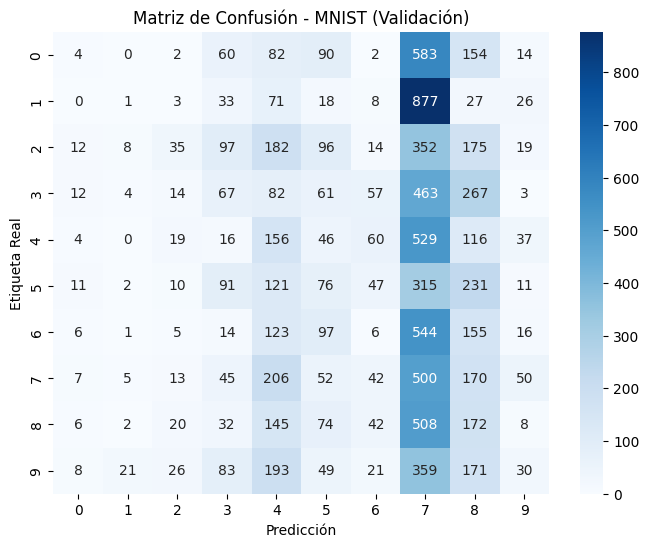

In [85]:
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, cmap="Blues", fmt="d")
plt.title("Matriz de Confusión - MNIST (Validación)")
plt.xlabel("Predicción")
plt.ylabel("Etiqueta Real")
plt.show()


<strong> Interpretacion: </strong> Esta clasificando todo como ocho (8) o nueve (9). Se esperaba que con esta red tengamos un accuracy elevado, en la matriz se veria la diagonal principal en azul.

## Intento de mejora

Inicialmente `torchvision.models.resnet34(pretrained=True)` descargamos el modelo entrenado. Ahora vamos descargar el modelo sin el entrenamiento y entrenaremos todas las capas para ver si existe una mejora.

In [86]:
resnet_model_v2 = torchvision.models.resnet34()
resnet_model_v2

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [87]:
num_features = resnet_model_v2.fc.in_features 
resnet_model_v2.fc = nn.Linear(num_features, 10)

In [88]:
n_epochs = 15
resnet_model_v2.to(device)
for idx_epoch in range(n_epochs):
    # Loop de entrenamiento
    loss_train_sum = 0
    n_batches_train = 0
    for x_train_batch, y_train_batch in train_dataloader:
        x_train_batch = x_train_batch.to(device, dtype=torch.float32)
        y_train_batch = y_train_batch.to(device, dtype=torch.int64)
        predictions = resnet_model_v2(x_train_batch)
        loss = loss_func(predictions, y_train_batch)
        loss_train_sum += loss.item()
        n_batches_train += 1
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    # Evaluamos los datos en validación
    loss_validation_sum = 0
    accuracy_sum = 0
    for x_valid_batch, y_valid_batch in valid_dataloader:
        x_valid_batch = x_valid_batch.to(device, dtype=torch.float32)
        y_valid_batch = y_valid_batch.to(device, dtype=torch.int64)
        predictions = resnet_model_v2(x_valid_batch)
        loss = loss_func(predictions, y_valid_batch)
        loss_validation_sum += loss.item()
        accuracy_sum += accuracy(predictions, y_valid_batch).item()
    
    # Imprimimos el loss en train y validación y la métrica (siempre en validación)
    accuracy_validation = accuracy_sum / n_batches_valid
    loss_validation = loss_validation_sum / n_batches_valid
    train_validation = loss_train_sum / n_batches_train
    print(f'epoch {idx_epoch} | train loss {loss_validation} | validation loss {train_validation} | accuracy {accuracy_validation}')

### Analisis matriz de confusión


In [90]:
resnet_model_v2.eval()  # Modo evaluación

all_preds = []
all_targets = []

misclassified_images = []
misclassified_preds = []
misclassified_labels = []

with torch.no_grad():
    for x_valid_batch, y_valid_batch in valid_dataloader:
        x_valid_batch = x_valid_batch.to(device, dtype=torch.float32)
        y_valid_batch = y_valid_batch.to(device, dtype=torch.int64)
        # forward pass
        predictions = resnet_model_v2(x_valid_batch)
        # argmax para obtener la clase predicha (0..9 en MNIST)
        pred_labels = predictions.argmax(dim=1)
        
        # Guardamos en listas (o tensores) para luego generar la matriz de confusión
        all_preds.append(pred_labels.cpu().numpy())  
        all_targets.append(y_valid_batch.cpu().numpy())
        for i in range(len(pred_labels)):
            if pred_labels[i] != y_valid_batch[i]:
                misclassified_images.append(x_valid_batch[i])
                misclassified_preds.append(pred_labels[i].item())
                misclassified_labels.append(y_valid_batch[i].item())

# Unimos todos los arreglos a lo largo de la primera dimensión
all_preds = np.concatenate(all_preds)
all_targets = np.concatenate(all_targets)


In [91]:
cm = confusion_matrix(all_targets, all_preds)
print("Matriz de confusión:\n", cm)


Matriz de confusión:
 [[ 32   0   4   7   3   7 133  57  10 738]
 [  5   2   3   1   1  21 188  75  61 707]
 [ 27   0   4   9   7   3 141 145  19 635]
 [ 19   0  17   3   4   1 150 112  25 699]
 [ 11   0   2   1   9  14 170  82  29 665]
 [ 17   0   3   0   7   7 147  90  23 621]
 [ 13   2   3   7   9  13 173  90  25 632]
 [ 21   0   8   4   3  11 170  55  40 778]
 [ 13   1   3   4  10   2 169  66  24 717]
 [ 20   0   6   3   6   4 150  86  28 658]]


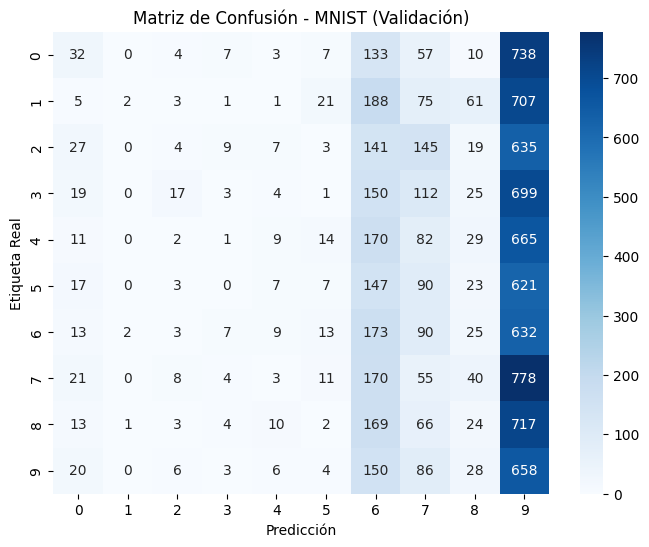

In [92]:
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, cmap="Blues", fmt="d")
plt.title("Matriz de Confusión - MNIST (Validación)")
plt.xlabel("Predicción")
plt.ylabel("Etiqueta Real")
plt.show()


<strong> Interpretacion: </strong> En esta nueva version esta clasificando la mayoria como nueve (9) y aparecieron muchas clasificaciones en seis (6).
Los resultados deberian ser mejor que los construidos con la primera red.